In [111]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

np.random.seed(0)

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict

import scikitplot as skplt


HELPERS

In [112]:
def run_cv_model(model_cls, model_params, X, y, feats, cv=3, scoring='neg_mean_absolute_error',plot_learning_curve=False, plot_feature_importances=False):

    scores = cross_val_score(model_cls(**model_params), X, y, cv=cv, scoring=scoring)
    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 3), np.round(np.std(scores), 3), scores))

    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);
    
    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X, y)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    

def change_pln_to_eur(row):
  if row['price_currency'] == 'PLN':
    return row
  elif row['price_currency'] == 'EUR':
    row['price_value'] = row['price_value']/4
    return row
  else:
    raise EnvironmentError

START

In [113]:
all_data = pd.read_hdf('./../output/final_feats.h5')

In [114]:
alll = set(all_data.columns)
grog =set(drogie_data.columns)

In [115]:
for column in all_data.columns.values:
    if (all_data[column] == drogie_data[column]).sum() != 160616:
        print(column)
    

created_at
price_details
price_value
param_engine-code
param_vin
param_kod-silnika
param_opłata-początkowa
param_monthly-payment-value
log_price
my_last
my_model_age


In [116]:
all_data = pd.read_hdf('drogie.h5')

FEATURE ENGINEERING

In [117]:
plus = 10000
def price_plus(row,plus):
  if row["price_value"] is not None:
    return np.log(row["price_value"] + plus)
all_data["log_price"] = all_data.apply(price_plus,plus=plus, axis=1)

In [118]:
moc_plusy = 0
def moc_plus(row,plus):
  if row["my_moc"] != -1:
    return np.log(row["my_moc"] + moc_plusy)
all_data["log_moc"] = all_data.apply(moc_plus,plus=moc_plusy, axis=1)


In [119]:
def moc_na_pojem(row):
  if (row["my_moc"] != -1) and (row["my_pojemnosc"] != -1):
    return row["my_moc"]/row["my_pojemnosc"]
  else:
    return -1

# all_data["moc_div_pojem"] = all_data.apply(moc_na_pojem, axis=1)

FEATURES ENGINEERING

In [120]:
dum_marka = pd.get_dummies(all_data["my_marka"], prefix="marka_")
all_data = pd.concat([all_data, dum_marka], axis=1)
del all_data["my_marka"]

In [121]:
dum_skrzynia = pd.get_dummies(all_data["my_skrzynia"], prefix="skrzynia_")
all_data = pd.concat([all_data, dum_skrzynia], axis=1)
del all_data["my_skrzynia"]

In [122]:
dum_naped = pd.get_dummies(all_data["my_naped"], prefix="naped_")
all_data = pd.concat([all_data, dum_naped], axis=1)
del all_data["my_naped"]

In [123]:
feats = all_data.select_dtypes(include=[np.number, np.bool]).columns

feats = feats[ feats != 'car_id' ].values
feats = feats[ feats != 'price_value' ]
feats = feats[ feats != 'log_price' ]

#feats = feats[feats != 'my_model'] 

assert len(feats) == len(set(feats))
assert 'car_id' not in feats
assert 'price_value' not in feats
assert 'log_price' not in feats

TRAIN / TEST SPLIT

In [124]:
train_all = all_data[~all_data.price_value.isnull()]
test = all_data[all_data.price_value.isnull()]

X_train_all = train_all[ feats ].values
y_train_all = train_all['log_price'].values

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, 
                                                      test_size=0.3, 
                                                      random_state=0, 
                                                      shuffle=True)

TRAIN AND VALIDATE

In [125]:
# first small model for important features selection and plots
model_cls = ctb.CatBoostRegressor
model_params = {"n_estimators":500, 
                "depth":10, 
                "random_state":0, 
                "verbose":False,
                }

In [126]:
model = model_cls(**model_params)
model.fit(X_train, y_train)

## predict
y_pred = model.predict(X_valid)

global_min = y_train.min()
y_pred[ y_pred < global_min] = global_min

y_pred_exp = np.exp(y_pred) - plus
y_valid_exp = np.exp(y_valid) - plus
mae = mean_absolute_error(y_valid_exp, y_pred_exp)

print("Score for validation: {}".format(mae))

Score for validation: 5780.339867095051


TRAIN CV

mean=-0.097, std=0.0, scores=[-0.09759407 -0.09690868 -0.09694923]


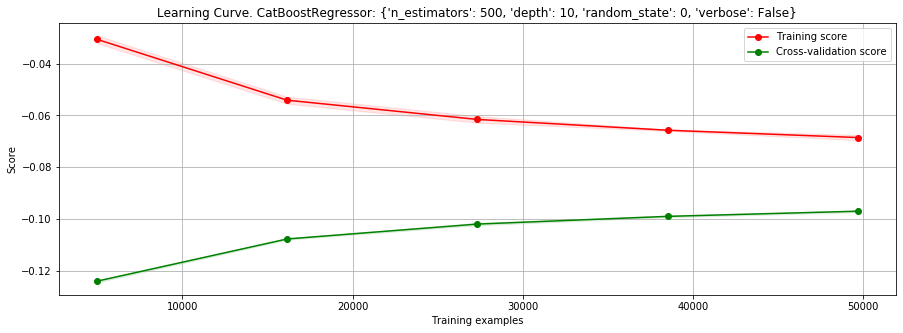

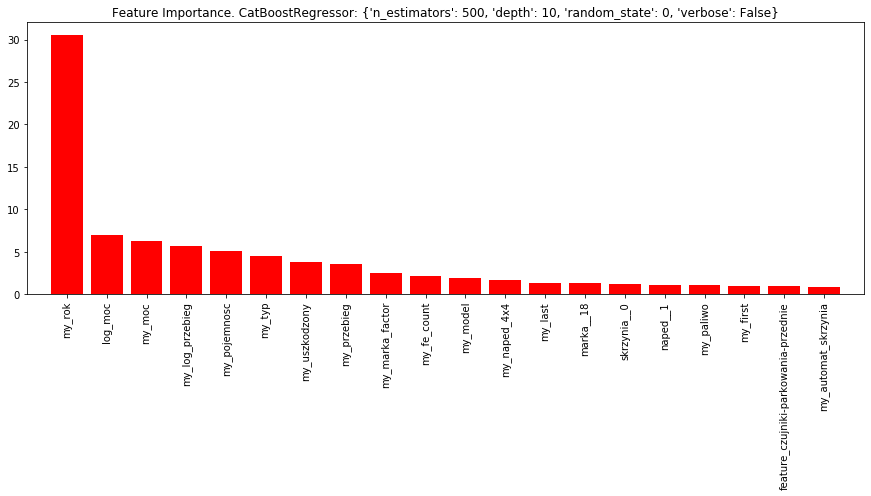

In [127]:
run_cv_model(model_cls, model_params, X_train, y_train, feats, cv=3, scoring='neg_mean_absolute_error', plot_learning_curve=True, plot_feature_importances=True)

GET RID OF UNIMPORTANT FEs 

In [128]:
aa = model.feature_importances_
aa.sort()
assert len(aa) == len(feats)
cutoff = aa[120]
important_features = []
for i, importance in enumerate(model.feature_importances_):
  if importance > cutoff:
    important_features.append(feats[i])
feats = important_features

TRAIN AND PREDICT

In [129]:
# final big model
model_cls = ctb.CatBoostRegressor
model_params = {"n_estimators":50000, 
                "depth":11, 
                "random_state":0, 
                "verbose":250,
                }

In [130]:
train_all = all_data[~all_data.price_value.isnull()]
test = all_data[all_data.price_value.isnull()]

X_train_all = train_all[ feats ].values
y_train_all = train_all['log_price'].values

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, 
                                                      test_size=0.3, 
                                                      random_state=0, 
                                                      shuffle=True)

In [ ]:
model = model_cls(**model_params)
model.fit(X_train_all, y_train_all)

train = all_data[all_data["price_value"].isnull()]
## predict
X_test = test[feats].values
y_pred = model.predict(X_test)

global_min = train.log_price.min()
y_pred[ y_pred < global_min] = global_min

test['price_value'] = np.exp(y_pred) - plus

test = test.apply(change_pln_to_eur, axis=1)

#prepare to submit
test[ ['car_id', 'price_value'] ].to_csv('./../output/final_result.csv', index=False)

Learning rate set to 0.004582
0:	learn: 0.7433756	total: 50.4ms	remaining: 42m 1s
250:	learn: 0.3335665	total: 12.6s	remaining: 41m 38s
500:	learn: 0.2238716	total: 25.1s	remaining: 41m 17s
